### Coursework 2

In this coursework you will be aiming to complete two classification tasks. 
Both the classification tasks relate to text classification tasks. 

One task is to be solved using Support Vector Machines. The other has to be solved using Boosting.

The specific tasks and the marking for the various tasks are provided in the notebook. Each task is expected to be accompanied by a lab-report. Each task can have a concise lab report that is maximum of one page in an A4 size. You will be expected to submit your Jupyter Notebook and all lab reports as a single zip file. You could have additional functions implemented that you require for carrying out each task.


#### Task 1

In this task, you need to obtain sentiment analysis for the provided dataset. The dataset consists of movie reviews with the sentiments being provided. The sentiments are either positive or negative. You need to train an SVM based classifier to obtain train and check on the sample test dataset provided. The method will be evaluated also against an external test set. Please do not hardcode any dimensions or number of samples while writing the code. It should be possible to automate the testing and hardcoding values does not allow for automated testing. 

You are allowed to use scikit-learn to implement the SVM. However, you are expected to write your own kernels.

You are allowed to use the existing library functions such as scikit-learn or numpy for obtaining the SVM. The main idea is to analyse the dataset using different kind of kernels. You are also supposed to write your own custom text kernels. Refer to the documentation provided [here](https://scikit-learn.org/stable/modules/svm.html) at 1.4.6.2 and an example [here](https://scikit-learn.org/stable/auto_examples/svm/plot_custom_kernel.html) for writing your own kernels.

Details regarding the marking have been provided in the coursework specification file. Ensure that the code can be run with different test files. 

In [19]:
import pandas as pd
import numpy as np
import csv
import nltk
import string
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report

## For stopwords that we need to exclude
from nltk.corpus import stopwords

## For ngrams example in task2
from nltk import ngrams

## For Stemming
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

import seaborn as sns
import matplotlib.pyplot as plt
import time

In [20]:
# new_stop = stopwords.words('english')
all_stopwords = stopwords.words('english')
# # print(all_stopwords)
# # for word in all_stopwords:
# #     all_stopwords.remove('not')
    
# # a = all_stopwords.remove("not")
new_stop = []
for i in all_stopwords:
    if i == 'not' or i == "don't" or i == "don'":
        pass
    else:
        new_stop.append(i)

In [21]:
def word_weight(y_pred_test):
    false_pos = []
    false_neg = []
    for i in range(len(y_pred_test)):
        if y_pred_test[i] == 1 and Y_test[i] == -1:
            false_pos.append(i)
        elif y_pred_test[i] == -1 and Y_test[i] == 1:
            false_neg.append(i)

    false_pos_lst = []
    false_neg_lst = []
    for x in false_pos:
        false_pos_lst.append(X_test[x])
    for x in false_neg:
        false_neg_lst.append(X_test[x])

    false_pos_weight = np.sum(false_pos_lst, axis =0).tolist()
    false_neg_weight = np.sum(false_neg_lst, axis =0).tolist()
    
    return false_pos_weight, false_neg_weight

def Nmaxelements(list1, N):
    final_list = []
    list2 = list(enumerate(list1))
    for i in range(0, N): 
        max1 = 0
        max_position = 0
          
        for j in range(len(list2)):
            if list2[j][1] > max1:
                max1 = list2[j][1]
                max_position = list2[j][0]
                  
        
        final_list.append((max_position,max1))
        list2.remove((max_position,max1))
        
          
    return final_list

In [22]:
def clean(dataset):
    corpus = []
    for i in range(len(dataset)):
        review = re.sub('[^a-zA-Z]', ' ', dataset['review'][i])
        review = review.lower()
        review = review.split()
        ps = PorterStemmer()
        all_stopwords = new_stop
        review = [ps.stem(word) for word in review if not word in set(all_stopwords)]
        review = [word for word in review if len(word) >= 3]
        review = ' '.join(review)
        corpus.append(review)
    return corpus

def numerial(x):
    if x == 'positive':
        return 1
    else:
        return 0
    
cv = TfidfVectorizer()

# Process the text and obtain a bag of words-based features 

In [23]:
def extract_bag_of_words_train_test(train_file, test_file):
    import numpy as np
    import nltk
    # Read the CSV file and extract Bag of Words Features
    train = pd.read_csv(train_file)
    test_old = pd.read_csv(test_file)
    test = test_old.iloc[:,:2]
    
    train['sentiment'] = train[pd.notnull(train['sentiment'])]['sentiment'].apply(numerial)
    test['sentiment'] = test[pd.notnull(test['sentiment'])]['sentiment'].apply(numerial)
    
    corpus_train = clean(train)
    corpus_test = clean(test)
    
    X_train = cv.fit_transform(corpus_train).toarray()
    y_train = train.iloc[:, -1].values
    y_train = y_train*2-1
    X_test = cv.transform(corpus_test).toarray()
    y_test = test.iloc[:, -1].values
    y_test = y_test*2-1
    
    
    return (X_train,y_train,X_test,y_test)

(X_train,Y_train,X_test,Y_test) = extract_bag_of_words_train_test('movie_review_train.csv', 'movie_review_test.csv')

# Cross Validation

In [24]:
words=cv.get_feature_names()
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.20, random_state = 32)

# 1. Sigmoid Kernel

## 1.1 Sigmoid Fine-Tuning

In [7]:
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.1,1], 'gamma': [1,0.1],'coef0':[0.8,0.5],'kernel': ['sigmoid']}
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=2)
grid.fit(X_train,Y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END ..........C=0.1, coef0=0.8, gamma=1, kernel=sigmoid; total time= 1.4min
[CV] END ..........C=0.1, coef0=0.8, gamma=1, kernel=sigmoid; total time= 1.4min
[CV] END ..........C=0.1, coef0=0.8, gamma=1, kernel=sigmoid; total time= 1.4min
[CV] END ..........C=0.1, coef0=0.8, gamma=1, kernel=sigmoid; total time= 1.4min
[CV] END ..........C=0.1, coef0=0.8, gamma=1, kernel=sigmoid; total time= 1.5min
[CV] END ........C=0.1, coef0=0.8, gamma=0.1, kernel=sigmoid; total time= 1.4min
[CV] END ........C=0.1, coef0=0.8, gamma=0.1, kernel=sigmoid; total time= 1.4min
[CV] END ........C=0.1, coef0=0.8, gamma=0.1, kernel=sigmoid; total time= 1.4min
[CV] END ........C=0.1, coef0=0.8, gamma=0.1, kernel=sigmoid; total time= 1.4min
[CV] END ........C=0.1, coef0=0.8, gamma=0.1, kernel=sigmoid; total time= 1.4min
[CV] END ..........C=0.1, coef0=0.5, gamma=1, kernel=sigmoid; total time= 1.4min
[CV] END ..........C=0.1, coef0=0.5, gamma=1, ker

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1], 'coef0': [0.8, 0.5], 'gamma': [1, 0.1],
                         'kernel': ['sigmoid']},
             verbose=2)

In [8]:
print(grid.best_estimator_)

SVC(C=1, coef0=0.8, gamma=1, kernel='sigmoid')


In [9]:
from sklearn.svm import SVC
svm_sig = SVC(kernel='sigmoid', random_state=32, coef0=0.8, C=1, gamma=1)
svm_sig.fit(X_train, Y_train)
y_pred = svm_sig.predict(X_val)

y_pred_t = svm_sig.predict(X_train)
print('training set prediction acc: ',accuracy_score(Y_train, y_pred_t))

y_pred = svm_sig.predict(X_val)
print('validation set prediction acc: ',accuracy_score(Y_val, y_pred))

## Test set
y_pred_test_sigmoid = svm_sig.predict(X_test)
print('test set prediction acc:',accuracy_score(Y_test, y_pred_test_sigmoid))

training set prediction acc:  0.91575
validation set prediction acc:  0.85
test set prediction acc: 0.872


## 1.2 Analysis of Sigmoid kernel

In [10]:
sigmoid_fp, sigmoid_fn = word_weight(y_pred_test_sigmoid)
final_false_pos_lst_sigmoid = Nmaxelements(sigmoid_fp, 5)
final_false_neg_lst_sigmoid = Nmaxelements(sigmoid_fn, 5)
print('Top 5 False Positive words in Sigmoid')
print(' ')
for i in final_false_pos_lst_sigmoid:
    print(words[i[0]], ':', i[1])

print(' ')
print(' ')
print('Top 5 False Negative words in Sigmoid')
print(' ')
for i in final_false_neg_lst_sigmoid:
    print(words[i[0]], ':', i[1])

Top 5 False Positive words in Sigmoid
 
movi : 4.418690902399458
film : 4.068672395696831
not : 2.6219436937781033
one : 2.5041794976387868
play : 2.350266932218392
 
 
Top 5 False Negative words in Sigmoid
 
movi : 5.873066352603637
like : 3.0673563308180087
film : 3.020491159038832
not : 2.9335391335859673
good : 2.8499174320691125


## 1.3 Confusion Matrix of Sigmoid Kernel

In [12]:
#Generate the confusion matrix
svmsig_matrix = confusion_matrix(Y_test, y_pred_test_sigmoid)


print(classification_report(Y_test, y_pred_test_sigmoid))

              precision    recall  f1-score   support

          -1       0.87      0.87      0.87       731
           1       0.88      0.87      0.87       769

    accuracy                           0.87      1500
   macro avg       0.87      0.87      0.87      1500
weighted avg       0.87      0.87      0.87      1500



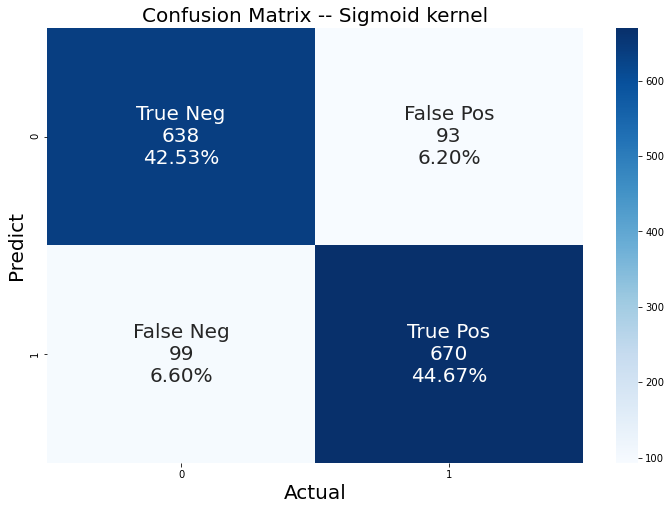

In [13]:
plt.figure(figsize=(12,8))

group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in svmsig_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in svmsig_matrix.flatten()/np.sum(svmsig_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(svmsig_matrix, annot=labels, fmt='', cmap='Blues', annot_kws={"size": 20})
ax.set_ylabel('Predict', fontsize=20)    
ax.set_xlabel('Actual',fontsize=20)
ax.set_title("Confusion Matrix -- Sigmoid kernel", fontsize=20)
plt.show()

# 2. RBF Kernel

## 2.1 RBF Kernel Fine-Tuning

In [14]:
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [1, 10], 'gamma': [1,0.1],'kernel': ['rbf']}
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=2)
grid.fit(X_train,Y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time= 2.0min
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time= 2.0min
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time= 2.0min
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time= 2.0min
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time= 2.0min
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time= 1.9min
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time= 1.9min
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time= 1.9min
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time= 1.9min
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time= 1.9min
[CV] END ..........................C=10, gamma=1, kernel=rbf; total time= 2.0min
[CV] END ..........................C=10, gamma=1,

GridSearchCV(estimator=SVC(),
             param_grid={'C': [1, 10], 'gamma': [1, 0.1], 'kernel': ['rbf']},
             verbose=2)

In [15]:
print(grid.best_estimator_)

SVC(C=10, gamma=1)


In [16]:
## Validation set
svm_rbf = SVC(kernel='rbf', random_state=32, gamma=1, C=10)
svm_rbf.fit(X_train, Y_train)

y_pred_t = svm_rbf.predict(X_train)
print('training set prediction acc: ',accuracy_score(Y_train, y_pred_t))

y_pred = svm_rbf.predict(X_val)
print('validation set prediction acc: ',accuracy_score(Y_val, y_pred))

## Test set
y_pred_test_rbf = svm_rbf.predict(X_test)
print('test set prediction acc:',accuracy_score(Y_test, y_pred_test_rbf))

training set prediction acc:  1.0
validation set prediction acc:  0.849
test set prediction acc: 0.87


## 2.2 Analysis of RBF kernel

In [17]:
rbf_fp, rbf_fn = word_weight(y_pred_test_rbf)
final_false_pos_lst_rbf = Nmaxelements(rbf_fp, 5)
final_false_neg_lst_rbf = Nmaxelements(rbf_fn, 5)
print('Top 5 False Positive words in RBF')
print(' ')
for i in final_false_pos_lst_rbf:
    print(words[i[0]], ':', i[1])

print(' ')
print(' ')
print('Top 5 False Negative words in RBF')
print(' ')
for i in final_false_neg_lst_rbf:
    print(words[i[0]], ':', i[1])

Top 5 False Positive words in RBF
 
movi : 5.035807543892971
film : 3.8109505804591413
not : 2.8935416967940735
one : 2.6782505912373376
play : 2.4881927081344455
 
 
Top 5 False Negative words in RBF
 
movi : 6.0914278539575
film : 3.192637958838685
like : 3.0238497207686534
not : 2.888048048667169
good : 2.681900178629767


In [18]:
svmrbf_matrix = confusion_matrix(Y_test, y_pred_test_rbf)

print(svmrbf_matrix)
print(classification_report(Y_test, y_pred_test_rbf))

[[638  93]
 [102 667]]
              precision    recall  f1-score   support

          -1       0.86      0.87      0.87       731
           1       0.88      0.87      0.87       769

    accuracy                           0.87      1500
   macro avg       0.87      0.87      0.87      1500
weighted avg       0.87      0.87      0.87      1500



## 2.3 Confusion Maxtrix of RBF Kernel

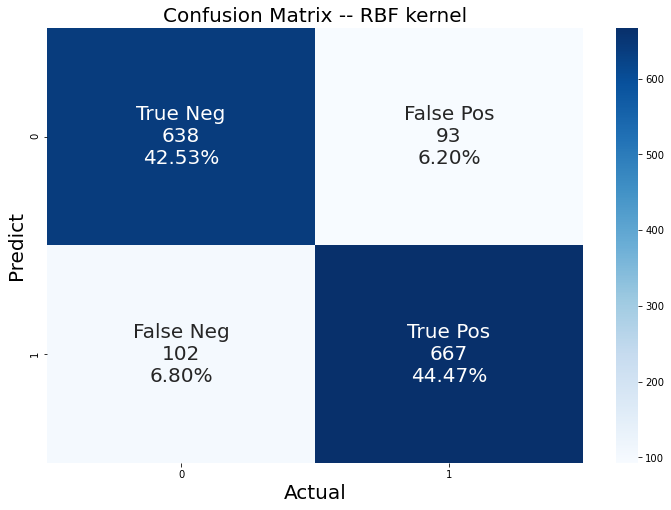

In [19]:
plt.figure(figsize=(12,8))

group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in svmrbf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in svmrbf_matrix.flatten()/np.sum(svmrbf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(svmrbf_matrix, annot=labels, fmt='', cmap='Blues', annot_kws={"size": 20})
ax.set_ylabel('Predict', fontsize=20)    
ax.set_xlabel('Actual',fontsize=20)
ax.set_title("Confusion Matrix -- RBF kernel", fontsize=20)
plt.show()

# 3. Customize Kernel (Polynomial Kernel)

In [20]:

gamma = 1
degree = 2
        
def kernel(X, Y):
   
    K = np.zeros((X.shape[0],Y.shape[0]))
    K = (gamma*X.dot(Y.T))**degree

    return K

class SVMClassifier:
    def __init__(self):
        self.clf = SVC(kernel = kernel)
        
    def fit(self, X, Y):
        return self.clf.fit(X,Y)
        
    def predict(self, X):
        return self.clf.predict(X)

### Test function that will be called to evaluate your code. Separate test dataset will be provided

Do not modify the code below. Please write your code above such that it can be evaluated by the function below. You can modify your code above such that you obtain the best performance through this function. 

In [21]:
def test_func_svm(dataset_train, dataset_test):
    from sklearn.metrics import accuracy_score  
    (X_train, Y_train, X_test, Y_test) = extract_bag_of_words_train_test(dataset_train, dataset_test)
    sc = SVMClassifier()
    sc.fit(X_train, Y_train)
    Y_Pred = sc.predict(X_test)
    acc = accuracy_score(Y_test, Y_Pred)
    print("Accuracy:",acc)
    return acc

## 3.1 Custom Kernel Fine-Tuning

In [22]:
gamma_lst = [1,0.1]
degree_lst = [2, 3]

gamma = 0
degree = 0

for g in gamma_lst:
    for d in degree_lst:
        gamma = g
        degree = d
        print('gamma=',gamma,'degree=',degree)
        acc = test_func_svm("movie_review_train.csv", "movie_review_test.csv")

gamma= 1 degree= 2
Accuracy: 0.8753333333333333
gamma= 1 degree= 3
Accuracy: 0.8333333333333334
gamma= 0.1 degree= 2
Accuracy: 0.48733333333333334
gamma= 0.1 degree= 3
Accuracy: 0.48733333333333334


In [23]:
gamma = 1
degree = 2

In [24]:
acc = test_func_svm("movie_review_train.csv", "movie_review_test.csv")

Accuracy: 0.8753333333333333


## 3.2 Analysis of Custom Kernel

In [25]:
sc = SVMClassifier()
sc.fit(X_train, Y_train)
Y_Pred = sc.predict(X_test)

custom_fp, custom_fn = word_weight(Y_Pred)
final_false_pos_lst_custom = Nmaxelements(custom_fp, 5)
final_false_neg_lst_custom = Nmaxelements(custom_fn, 5)
print('Top 5 False Positive words in Custom')
print(' ')
for i in final_false_pos_lst_custom:
    print(words[i[0]], ':', i[1])

print(' ')
print(' ')
print('Top 5 False Negative words in Custom')
print(' ')
for i in final_false_neg_lst_custom:
    print(words[i[0]], ':', i[1])

Top 5 False Positive words in Custom
 
movi : 5.337675290343167
film : 4.513189175631588
not : 3.3104998024901504
one : 3.136880196562485
show : 2.8213941902649764
 
 
Top 5 False Negative words in Custom
 
movi : 5.669915632823062
like : 2.741856239243833
not : 2.7023393085900875
film : 2.610928266020233
good : 2.4103014189599223


In [26]:
## Train set
# sc = SVMClassifier()
# sc.fit(X_train, Y_train)
y_pred_t = sc.predict(X_train)
# print('training set prediction acc: ',accuracy_score(Y_train, y_pred_t))

## Test set
y_pred_test = sc.predict(X_test)
# print('test set prediction acc:',accuracy_score(Y_test, y_pred_test))

svmself_matrix = confusion_matrix(Y_test, y_pred_test)

print(svmself_matrix)
print(classification_report(Y_test, y_pred_test))

[[613 118]
 [ 78 691]]
              precision    recall  f1-score   support

          -1       0.89      0.84      0.86       731
           1       0.85      0.90      0.88       769

    accuracy                           0.87      1500
   macro avg       0.87      0.87      0.87      1500
weighted avg       0.87      0.87      0.87      1500



## 3.3 Confusion Matrix of Custom Kernel

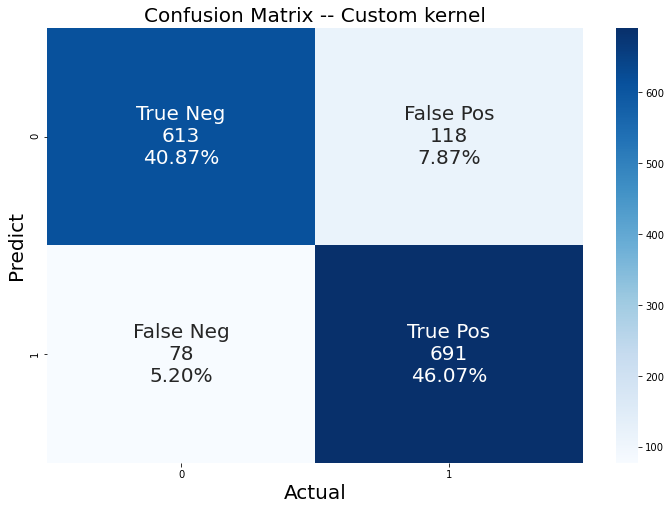

In [27]:
plt.figure(figsize=(12,8))

group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in svmself_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in svmself_matrix.flatten()/np.sum(svmself_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(svmself_matrix, annot=labels, fmt='', cmap='Blues', annot_kws={"size": 20})
ax.set_ylabel('Predict', fontsize=20)    
ax.set_xlabel('Actual',fontsize=20)
ax.set_title("Confusion Matrix -- Custom kernel", fontsize=20)
plt.show()

### Task 2

In this task you need to implement a boosting based classifier that can be used to classify the images. 

Details regarding the marking for the coursework are provided in the coursework specification file. Please ensure that your code will work with a different test file than the one provided with the coursework.

Note that the boosting classifier you implement can include decision trees from scikit-learn or your own decision trees. Use the same sentiment analysis dataset for evaluation.

In [25]:
def compute_error(y, y_pred, w):
    return (sum(w * (np.not_equal(y, y_pred)).astype(int)))/sum(w)

def compute_alpha(error):
    return np.log((1 - error) / error)

def update_weights(w, alpha, y, y_pred):
    return w * np.exp(alpha * (np.not_equal(y, y_pred)).astype(int))

In [26]:
from sklearn.tree import DecisionTreeClassifier
class BoostingClassifier():
    
    def __init__(self):
        self.alphas = []
        self.weak_classifier = []
        self.n_estimater = None
        self.train_error = []

    def fit(self, X, y):
        self.alphas = [] 
        self.train_error = []
        self.n_estimater = n_estimater

        # Iterate weak classifiers
        for m in range(0, n_estimater):
            
            # Set weights for current boosting
            if m == 0:
                w = np.ones(len(y)) * 1 / len(y)
            else:
                # Update weight
                w = update_weights(w, alpha_m, y, y_pred)
            
            # Fit weak classifier and predict
            tree = DecisionTreeClassifier(max_depth=max_depth)
            tree.fit(X, y, sample_weight = w)
            y_pred = tree.predict(X)
            
             # Save to list of weak classifiers
            self.weak_classifier.append(tree)

            # Compute error
            error_m = compute_error(y, y_pred, w)
            self.train_error.append(error_m)

            # Compute alpha
            alpha_m = compute_alpha(error_m)
            self.alphas.append(alpha_m)

        assert len(self.weak_classifier) == len(self.alphas)
        
    def predict(self, X):
        
        # Initialise dataframe with weak predictions for each observation
        weak_preds = pd.DataFrame(index = range(len(X)), columns = range(self.n_estimater)) 

        # Predict class label for each weak classifier, weighted by alpha_m
        for m in range(self.n_estimater):
            y_pred_m = self.weak_classifier[m].predict(X) * self.alphas[m]
            weak_preds.iloc[:,m] = y_pred_m

        # Calculate final predictions
        y_pred = (1 * np.sign(weak_preds.T.sum())).astype(int)

        return y_pred

In [27]:
def test_func_boosting(dataset_train, dataset_test):
    from sklearn.metrics import accuracy_score    
    (X_train, Y_train, X_test, Y_test) = extract_bag_of_words_train_test(dataset_train, dataset_test)
    bc = BoostingClassifier()
    bc.fit(X_train, Y_train)
    Y_Pred = bc.predict(X_test)    
    acc = accuracy_score(Y_test, Y_Pred)
    print("Accuracy:",acc)
    return acc

## 4.1 Boosting Fine-Tuning

In [28]:
depth_lst = [1,2]
estimator_lst = [100,400]

max_depth = 0
n_estimater = 0

for d in depth_lst:
    for n in estimator_lst:
        starttime = time.time()
        max_depth = d
        n_estimater = n
        
        print('max_depth = ',max_depth,'n_estimater = ',n_estimater)
        acc = test_func_boosting("movie_review_train.csv", "movie_review_test.csv")
        print('total time:',((round(time.time()-starttime)/60)), 'mins')
        print(' ')
print('----------------end------------------')

max_depth =  1 n_estimater =  100
Accuracy: 0.8033333333333333
total time: 4.483333333333333 mins
 
max_depth =  1 n_estimater =  400
Accuracy: 0.8346666666666667
total time: 16.683333333333334 mins
 
max_depth =  2 n_estimater =  100
Accuracy: 0.816
total time: 7.35 mins
 
max_depth =  2 n_estimater =  400
Accuracy: 0.8366666666666667
total time: 29.55 mins
 
----------------end------------------


### Test function that will be called to evaluate your code. Separate test dataset will be provided

Do not modify the code below. Please write your code above such that it can be evaluated by the function below. You can modify your code above such that you obtain the best performance through this function. 

In [29]:
max_depth=1
M = 400

In [30]:
acc = test_func_boosting("movie_review_train.csv", "movie_review_test.csv")

Accuracy: 0.8346666666666667


## Analysis of AdaBoost

In [31]:
bc = BoostingClassifier()
bc.fit(X_train, Y_train)
Y_Pred = bc.predict(X_test)

ada_fp, ada_fn = word_weight(Y_Pred)
final_false_pos_lst_ada = Nmaxelements(ada_fp, 5)
final_false_neg_lst_ada = Nmaxelements(ada_fn, 5)
print('Top 5 False Positive words in AdaBoost')
print(' ')
for i in final_false_pos_lst_ada:
    print(words[i[0]], ':', i[1])

print(' ')
print(' ')
print('Top 5 False Negative words in AdaBoost')
print(' ')
for i in final_false_neg_lst_ada:
    print(words[i[0]], ':', i[1])

Top 5 False Positive words in AdaBoost
 
movi : 9.286014087337378
film : 6.2459819939158745
not : 4.7278729079116495
one : 3.9986830761156367
watch : 3.7276481219304705
 
 
Top 5 False Negative words in AdaBoost
 
movi : 5.42476512700477
film : 4.6254127600246315
not : 3.536639444009536
like : 3.4642532431447823
good : 3.282349756250772


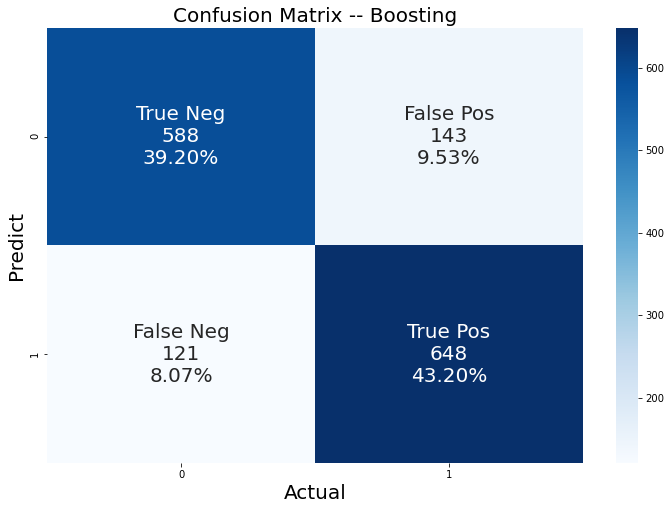

In [32]:
bc_matrix = confusion_matrix(Y_test, Y_Pred)

plt.figure(figsize=(12,8))

group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in bc_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in bc_matrix.flatten()/np.sum(bc_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(bc_matrix, annot=labels, fmt='', cmap='Blues', annot_kws={"size": 20})
ax.set_ylabel('Predict', fontsize=20)    
ax.set_xlabel('Actual',fontsize=20)
ax.set_title("Confusion Matrix -- Boosting", fontsize=20)
plt.show()